In [1]:
import scanpy as sc
from scprint import scPrint
from scdataloader import Preprocessor
from scprint.tasks import GRNfer
import umap

from grnndata import GRNAnnData, read_h5ad, from_anndata
from grnndata import utils 
from bengrn import BenGRN, get_sroy_gt


import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from collections import Counter
from scprint.tasks.grn import get_GTdb


%load_ext autoreload
%autoreload 2

import torch
torch.set_float32_matmul_precision('medium')

💡 connected lamindb: jkobject/scprint


/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/umap/__init__.py:9: ImportWarning: Tensorflow not installed; ParametricUMAP will be unavailable
  warn(
2024-04-11 16:04:23,425:INFO - Downloading data from `https://omnipathdb.org/queries/enzsub?format=json`
2024-04-11 16:04:23,547:INFO - Downloading data from `https://omnipathdb.org/queries/interactions?format=json`
2024-04-11 16:04:23,635:INFO - Downloading data from `https://omnipathdb.org/queries/complexes?format=json`
2024-04-11 16:04:23,721:INFO - Downloading data from `https://omnipathdb.org/queries/annotations?format=json`
2024-04-11 16:04:23,807:INFO - Downloading data from `https://omnipathdb.org/queries/intercell?format=json`
2024-04-11 16:04:23,984:INFO - Downloading data from `https://omnipathdb.org/about?format=text`
/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/arboreto/core.py:12: DeprecationWarning: The current Dask DataFrame implementation is deprecated. 
In a future release, Dask D

# Load Model and data

In [2]:
#model = scPrint.load_from_checkpoint('../../data/tensorboard/scprint_test/urxxwu28/checkpoints/epoch=0-step=20000.ckpt') #chocolate-surf-8
model = scPrint.load_from_checkpoint('../../data/temp/za9mg1w3/epoch=7-step=40000.ckpt', precpt_gene_emb = '../../data/main/gene_embeddings.parquet')
# ../../data/temp/epoch=4-step=12500.ckpt latest model maestro (fortuitous laugther)
# ../../data/logs/scprint_test/f4vao230/checkpoints/epoch=10-step=27500.ckpt looked good as a training run (vermlillion noodle)
# d1792z9k/epoch=3-step=10000.ckpt
# '../../data/temp/d1792z9k/epoch=3-step=10000.ckpt'
# '../../data/temp/6q3dzi3x/epoch=3-step=10000.ckpt'
# '../../data/temp/grsachbg/epoch=2-step=15000.ckpt'
## post debug
# "../lightning_logs/version_14/checkpoints/epoch=1-step=5000.ckpt"

In [3]:
preadata = get_sroy_gt(join="inner")
preadata
# preadata = preadata[preadata.obs["dataset"] == "liu", np.isnan(preadata[preadata.obs["dataset"] == "liu"].copy().X).sum(0)==0].copy()

/home/ml4ig1/Documents code/GRnnData/grnndata/GRNAnnData.py:218: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  da = np.zeros((len(varnames), len(varnames)), dtype=np.float)


GRnnData object with n_obs × n_vars = 457 × 7813
    obs: 'dataset'
    varp: 'GRN'
    with a grn of 2817 elements

In [4]:
preprocessor = Preprocessor(is_symbol=True, force_preprocess=True, skip_validate=True, do_postp=False, min_valid_genes_id=5000)

In [5]:
preadata.obs['organism_ontology_term_id'] = "NCBITaxon:9606"
adata = preprocessor(preadata.copy())
preadata.obs

Dropping layers:  KeysView(Layers with keys: )
checking raw counts
Data is not raw counts, please check layers, find raw data, or bypass with force_preprocess
removed 0 non primary cells, 457 renamining
filtered out 0 cells, 457 renamining
Removed 0 genes.
startin QC
Seeing 97 outliers (21.23% of total dataset):
done


,dataset,organism_ontology_term_id
CL100078088_L01_501,liu,NCBITaxon:9606
CL100078088_L01_502,liu,NCBITaxon:9606
CL100078088_L01_503,liu,NCBITaxon:9606
CL100078088_L01_507,liu,NCBITaxon:9606
CL100078088_L01_510,liu,NCBITaxon:9606
...,...,...
TGTAATCATCTG,chen,NCBITaxon:9606
GTTCTTCCTAGT,chen,NCBITaxon:9606
ATCCGTTCAACG,chen,NCBITaxon:9606
AAGCCTGGGGGC,chen,NCBITaxon:9606


In [6]:
grn_inferer = GRNfer(model, adata,
    how="most var within",
    preprocess="softmax",
    head_agg='none',
    cell_agg="mean",
    filtration="none",
    forward_mode="none",
    apc=False,
    symmetrize=False,
    max_cells=64,
    #k=
    #genes=
    #known_grn
)
#grn = grn_inferer(layer=list(range(model.nlayers))[:4])

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


number of expressed genes in this cell type: 7586


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

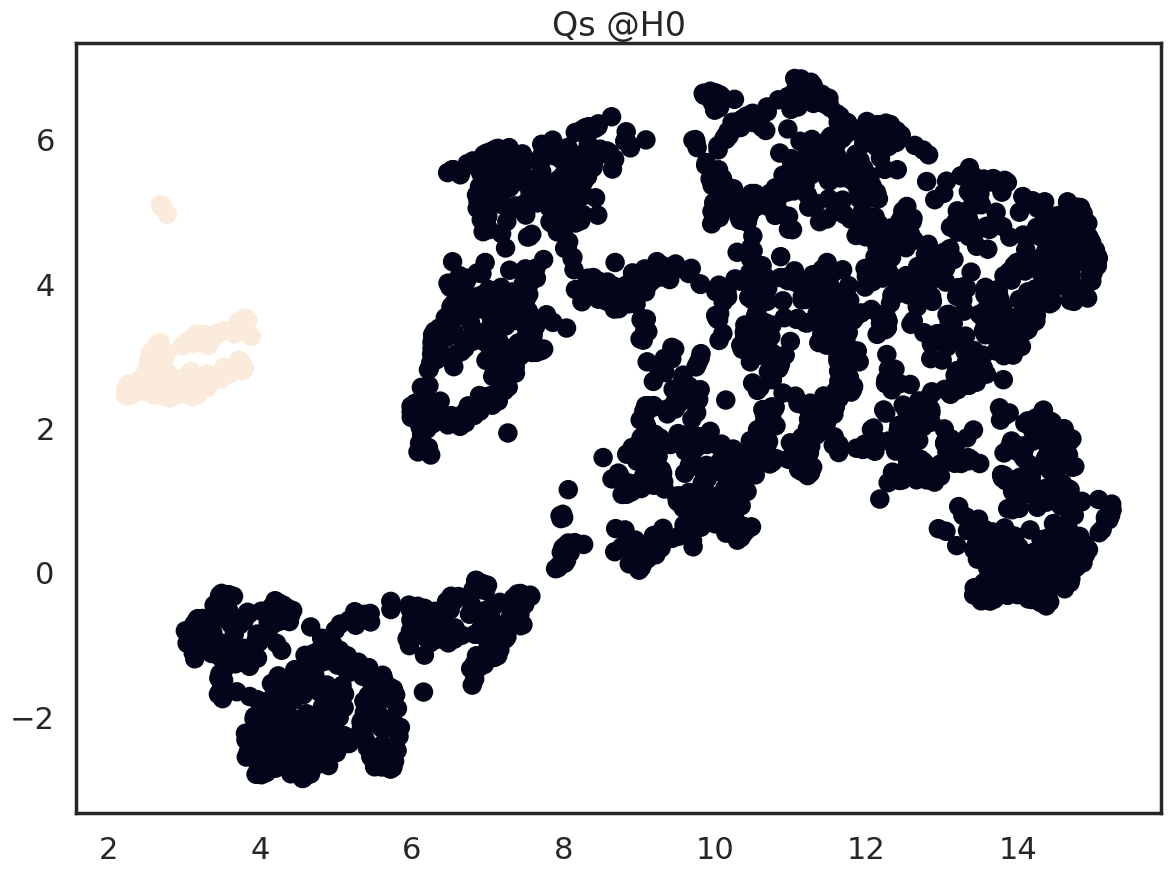

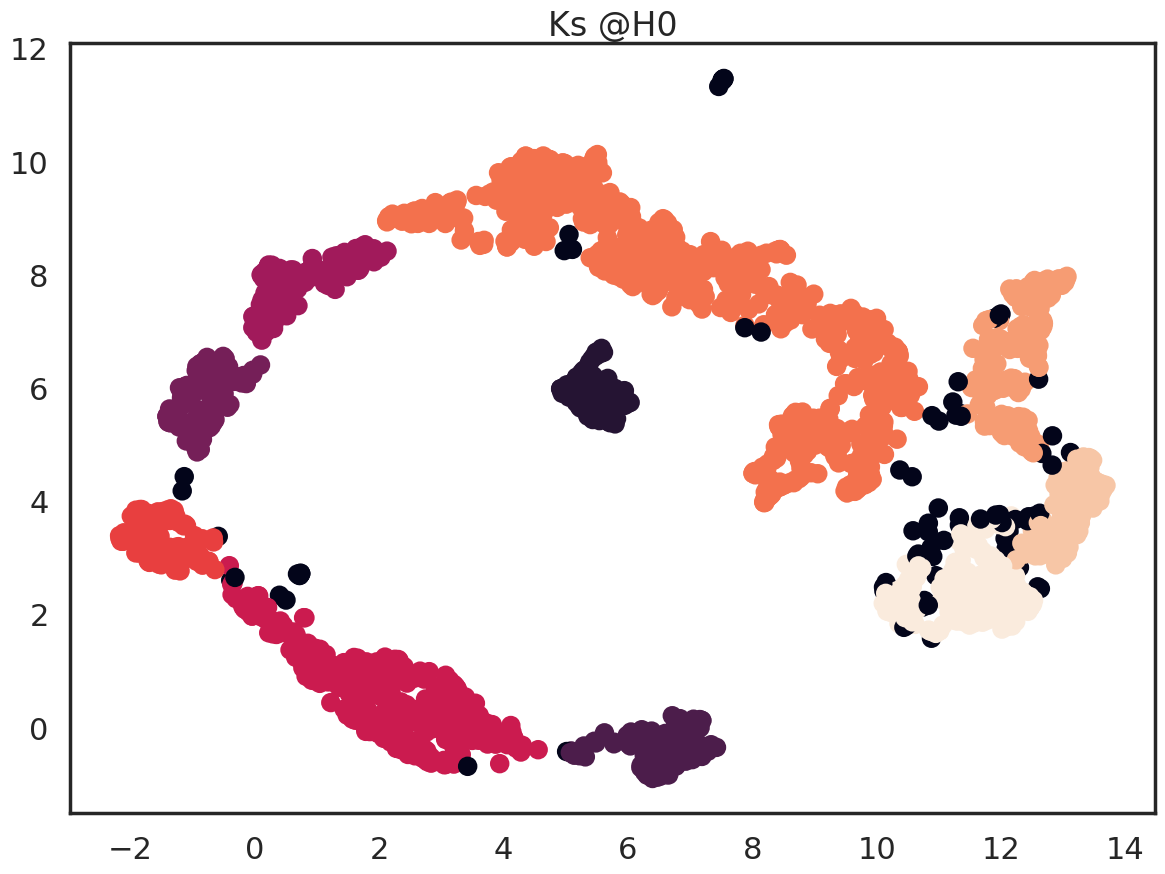

In [41]:
grn = grn_inferer.predict(layer=list(range(model.nlayers))[0:])
adj = grn_inferer.aggregate(grn_inferer.model.mean_attn)

In [42]:
adj = adj.reshape(-1, adj.shape[-2], adj.shape[-1]).T
loc = np.array((adata[:, adata.var.index.isin(grn_inferer.curr_genes)].X!=0).sum(0)>2)[0]
curr_genes = adata[:, adata.var.index.isin(np.array(grn_inferer.curr_genes)[loc].tolist())].var.symbol.tolist()
adj = adj[8:, 8:, :][loc, : ,:][:,loc,:]
np.save('adj_all.npy', adj)

In [21]:
np.save('adj2.npy', adj)

In [10]:
adj = np.load("adj2.npy")

In [32]:
from bengrn.base import get_GT_db
gt = get_GT_db(name="omnipath")

In [ ]:
# we

In [43]:
varnames = set(gt.iloc[:, :2].values.flatten())
intersection = varnames & set(curr_genes)

loc = np.isin(curr_genes, np.array(list(intersection)))
curr_genes = np.array(curr_genes)[loc].tolist()
sadj = adj[:, loc, :][loc, :, :]

da = np.zeros((len(curr_genes), len(curr_genes)), dtype=np.float)
for i, j in gt.iloc[:,:2].values:
    if i in curr_genes and j in curr_genes:
        da[curr_genes.index(i), curr_genes.index(j)] = 1
print("true elem", da.sum()), print("n elem", da.shape[0]**2)

/tmp/ipykernel_664688/1899844792.py:8: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  da = np.zeros((len(curr_genes), len(curr_genes)), dtype=np.float)


true elem 6331.0
n elem 4426816


(None, None)

In [34]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import PrecisionRecallDisplay
from sklearn.model_selection import train_test_split


In [44]:
da = da.flatten()
sadj = sadj.reshape(-1, adj.shape[-1])


In [ ]:
# we would want between 1/400 and 1/40 sparsity in the data
# here that would mean for 4_000_000 between 10_000 and 100_000

coef [[ 0.00000000e+00 -4.33716957e+01  0.00000000e+00  0.00000000e+00
   0.00000000e+00 -7.98224527e+01  0.00000000e+00  0.00000000e+00
  -4.79892761e+02  2.77609165e+02  0.00000000e+00 -1.27114784e+00
  -4.30818753e+01 -1.77559152e+02  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  1.57975159e+02 -4.24026997e+02
  -6.98377960e+01  1.59970476e+00 -4.03367365e+02  0.00000000e+00
   1.09000934e+02  0.00000000e+00  0.00000000e+00 -1.23108620e+02
   0.00000000e+00  1.08164165e+01  0.00000000e+00 -6.23640651e+01
  -1.79034193e+02  0.00000000e+00  0.00000000e+00  1.56700732e+01
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  -3.30220571e+01  0.00000000e+00 -5.13974382e+01 -6.46069936e+02
  -4.99153620e+01  0.00000000e+00  0.00000000e+00  1.75512895e+02
   0.00000000e+00  0.00000000e+00  3.37488843e+02  7.73794924e+01
   3.17084831e+02  0.00000000e+00  0.00000000e+00  2.36334422e+02
   0.00000000e+00  0.00000000e+00  0.00000000e+00 -6.49464438e+02
   3.

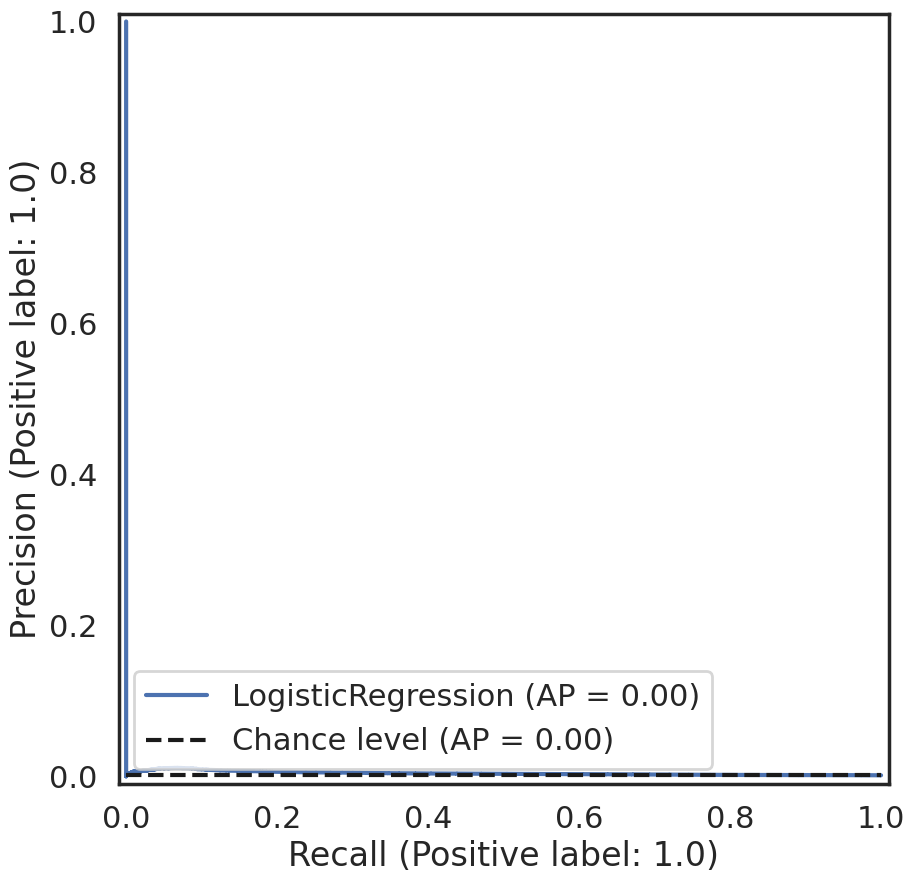

In [48]:
X_train, X_test, y_train, y_test = train_test_split(sadj, da, random_state=0, train_size=1_000_000)

clf = LogisticRegression(penalty="l1", C=0.4, solver="liblinear", class_weight={1:200,0:1}, max_iter=4_000, n_jobs=8)
clf.fit(X_train, y_train)
print("coef", clf.coef_)

pred = clf.predict(X_test)
print("precision", (pred[y_test==1]==1).sum()/(pred==1).sum())
print("random precision", y_test.sum()/len(y_test))
print("recall", (pred[y_test==1]==1).sum()/y_test.sum())
print("random recall", pred.sum()/len(pred))
print("predicted true", pred.sum())
print("number of true", y_test.sum())
PrecisionRecallDisplay.from_estimator(clf, X_test, y_test, plot_chance_level=True)
plt.show()

random recall 0.010606902212611092
 0.010606902212611092


coef [[    0.           103.29988282    88.0104776    -69.9640818
    683.35646641     0.           -96.23480484   104.15094381
      0.            99.81439361     0.         -1413.68827346
     20.96110763     0.             9.82111358     0.
     50.2658235    654.3126556    438.23738975     0.
    181.7255054  -1231.87519768  1126.78206836  1273.31567115
      0.             0.          -213.19371318     0.
      0.          -238.49275513  -615.32703535     0.
      0.             0.             5.60022502     0.
      0.             0.          -950.50477557   -35.05424499
     40.70129578     0.             0.             7.41144233
     -4.56368441    13.29933764   513.81879081  -166.72945844]]
precision 0.012093829864914201
random precision 0.0027220603615717913
recall 0.028409090909090908
predicted true 21912.0
number of true 9328.0


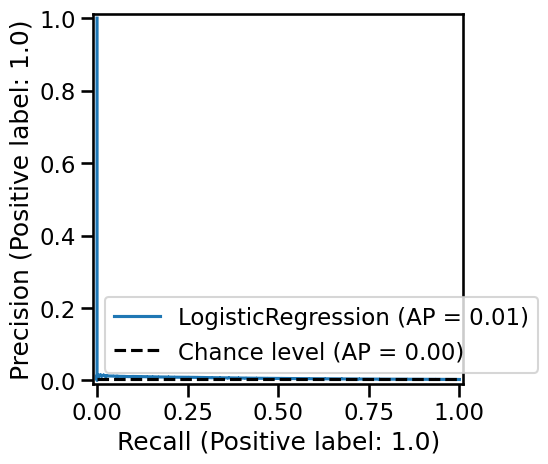

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(sadj, da, random_state=0, train_size=2_000_000)

clf = LogisticRegression(penalty="l1", C=1, solver="liblinear", class_weight={1:100,0:1}, max_iter=2_000, n_jobs=8)
clf.fit(X_train, y_train)
print("coef", clf.coef_)

pred = clf.predict(X_test)
print("precision", (pred[y_test==1]==1).sum()/(pred==1).sum())
print("random precision", y_test.sum()/len(y_test))
print("recall", (pred[y_test==1]==1).sum()/y_test.sum())
print("random recall", pred.sum()/len(pred))
print("predicted true", pred.sum())
print("number of true", y_test.sum())
PrecisionRecallDisplay.from_estimator(clf, X_test, y_test, plot_chance_level=True)
plt.show()

coef [[    0.           131.86821567   147.03328061   -75.47751054
    679.31545208  -134.08443075   -76.65838607   152.99224318
      0.           178.07296744     0.         -1628.35464061
      0.             0.            17.55981802     0.
     61.19211849  1257.74718367   886.38309982     0.
    215.05865419 -1598.68835607  1412.08416478  1345.16835634
      0.            34.00705159  -354.23544563     0.
      0.          -269.69481938  -699.14244567     0.
      0.            -6.10540689     0.           -13.44642464
      0.             0.          -855.06916229   -43.91523961
     45.62467785     0.             0.            23.73603456
    -26.08073745    15.31211511   562.32874075  -211.12576457]]
precision 0.009278890524057769
random precision 0.0027220603615717913
recall 0.19939965694682676
predicted true 200455.0
number of true 9328.0


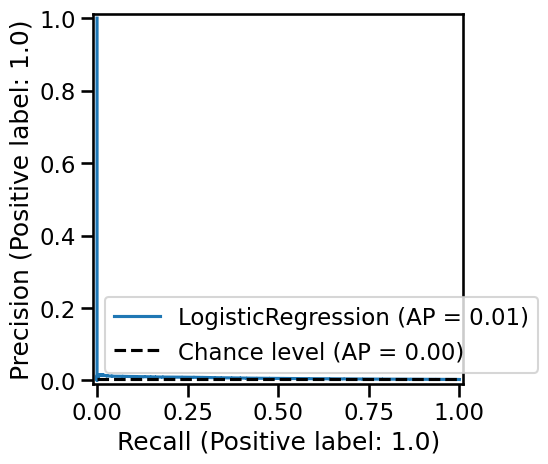

In [17]:
X_train, X_test, y_train, y_test = train_test_split(sadj, da, random_state=0, train_size=1_000_000)

clf = LogisticRegression(penalty="l1", C=1, solver="liblinear", class_weight={1:200,0:1}, max_iter=4_000, n_jobs=8)
clf.fit(X_train, y_train)
print("coef", clf.coef_)

pred = clf.predict(X_test)
print("precision", (pred[y_test==1]==1).sum()/(pred==1).sum())
print("random precision", y_test.sum()/len(y_test))
print("recall", (pred[y_test==1]==1).sum()/y_test.sum())
print("random recall", pred.sum()/len(pred))
print("predicted true", pred.sum())
print("number of true", y_test.sum())
PrecisionRecallDisplay.from_estimator(clf, X_test, y_test, plot_chance_level=True)
plt.show()

In [9]:
from bengrn import compute_genie3, compute_scenic

In [10]:
subadata = adata[:, adata.var.symbol.isin(curr_genes)]
print(subadata)
grn = compute_genie3(subadata, nthreads=32)

View of AnnData object with n_obs × n_vars = 457 × 3321
    obs: 'dataset', 'organism_ontology_term_id', 'nnz', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'mt_outlier'
    var: 'uid', 'symbol', 'ncbi_gene_ids', 'biotype', 'description', 'synonyms', 'organism_id', 'public_source_id', 'created_by_id', 'mt', 'ribo', 'hb', 'organism', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'unseen_genes'
Tree method: RF
K: sqrt
Number of trees: 100


running jobs on 32 threads
Elapsed time: 45.84 seconds


/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/multiprocessing/pool.py:265: ResourceWarning: unclosed running multiprocessing pool <multiprocessing.pool.Pool state=RUN pool_size=32>
  _warn(f"unclosed running multiprocessing pool {self!r}",


base enrichment
Top central genes: []


2024-04-10 14:51:41,374 [WARNING] Duplicated values found in preranked stats: 0.43% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


[]


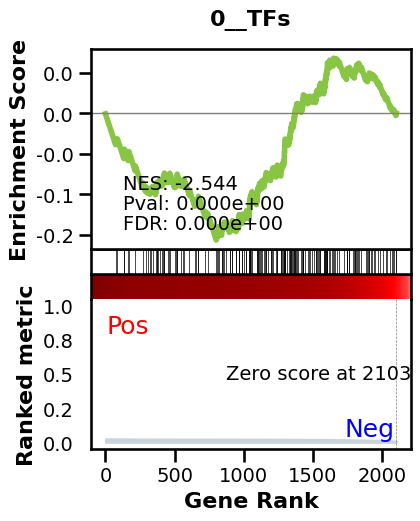

[]


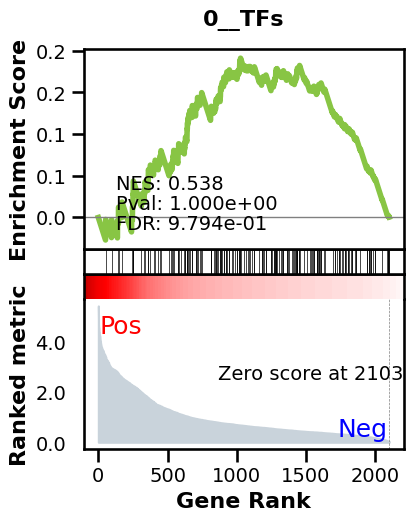

_________________________________________
TF specific enrichment


2024-04-10 14:51:43,932:INFO - Downloading and generating Enrichr library gene sets...
2024-04-10 14:51:43,943:INFO - Library is already downloaded in: /home/ml4ig1/.cache/gseapy/Enrichr.ENCODE_TF_ChIP-seq_2014.gmt, use local file
2024-04-10 14:51:44,169:INFO - 0332 gene_sets have been filtered out when max_size=2000 and min_size=0
2024-04-10 14:51:44,180 [WARNING] Duplicated values found in preranked stats: 24.95% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-04-10 14:51:44,323 [WARNING] Duplicated values found in preranked stats: 43.35% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-04-10 14:51:44,489 [WARNING] Duplicated values found in preranked stats: 29.56% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-04-10 14:51:44,644 [WARNING] Duplicated values found in preranked stats: 35.55% of genes
The order of those genes will be arbitrary, 

found some significant results for  0.0 % TFs

_________________________________________
loading GT,  omnipath
intersection of 2104 genes
intersection pct: 1.0
precision:  0.004484202116261207 
recall:  0.8476412735455909 
random recall: 0.8305253197283097



100%|██████████| 49/49 [00:03<00:00, 15.18it/s]


Area Under Precision-Recall Curve (AUPRC):  0.004043575743983831
random precision is:  0.004393655090385227
overal increase: (mean, max) (0.0021448172601654446, 0.01711595381728126)
true_positive 36
True Negative:  1351891.0
False Positive:  5836
False Negative:  5963
Odds Ratio:  1.3985051983231758


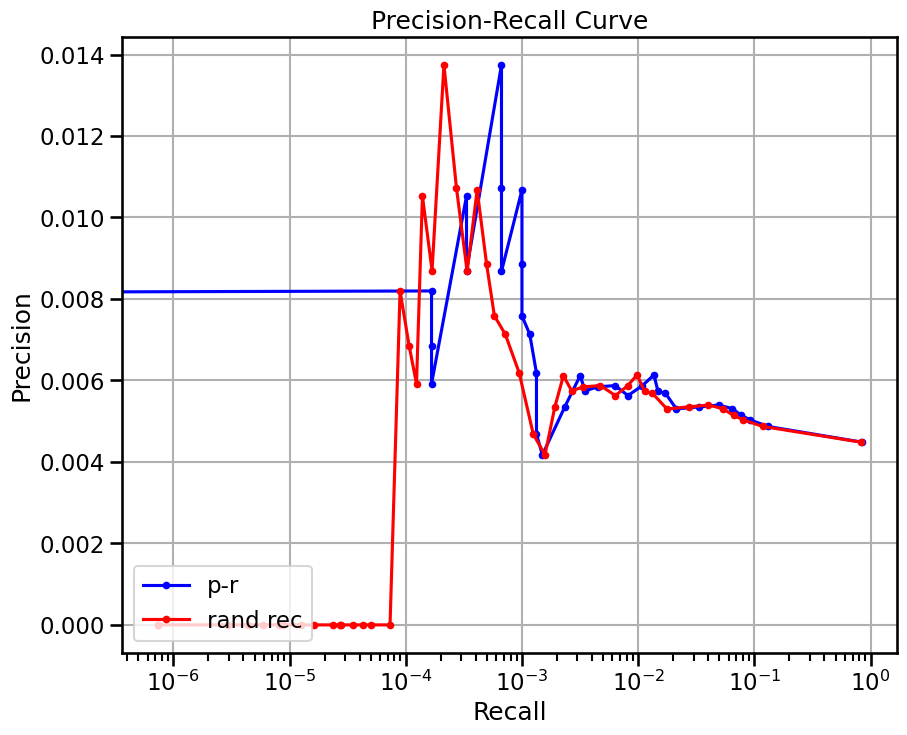

{'significant_enriched_TFtargets': 0.0,
 'auprc': 0.004043575743983831,
 'pr_increase_to_random': (0.0021448172601654446, 0.01711595381728126)}

In [31]:
BenGRN(grn).scprint_benchmark()

# run it with TF only


In [55]:
from grnndata import utils

In [90]:
subadata.var["isTF"]=False
subadata.var.loc[subadata.var.symbol.isin(utils.TF), "isTF"]=True

In [91]:
grn = compute_genie3(subadata, nthreads=32, regulators=subadata.var[subadata.var.isTF].index.tolist())

Tree method: RF
K: sqrt
Number of trees: 100


running jobs on 32 threads


Elapsed time: 33.24 seconds


/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/multiprocessing/pool.py:265: ResourceWarning: unclosed running multiprocessing pool <multiprocessing.pool.Pool state=RUN pool_size=32>
  _warn(f"unclosed running multiprocessing pool {self!r}",
[rank: 0] Received SIGTERM: 15
[rank: 0] Received SIGTERM: 15
[rank: 0] Received SIGTERM: 15
[rank: 0] Received SIGTERM: 15
[rank: 0] Received SIGTERM: 15


base enrichment


Top central genes: []


2024-04-10 15:56:13,291 [WARNING] Duplicated values found in preranked stats: 80.13% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


['0__TFs', 'celltype.gmt__Embryonic stem cells', 'celltype.gmt__Epiblast cells']


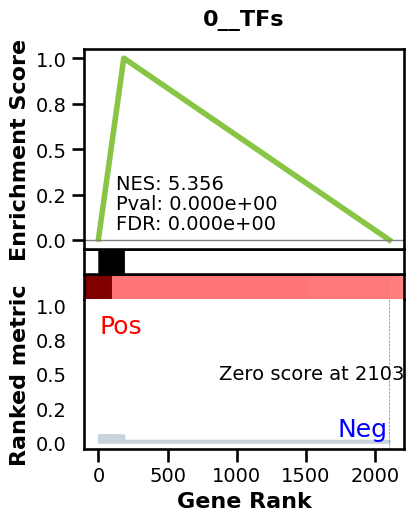

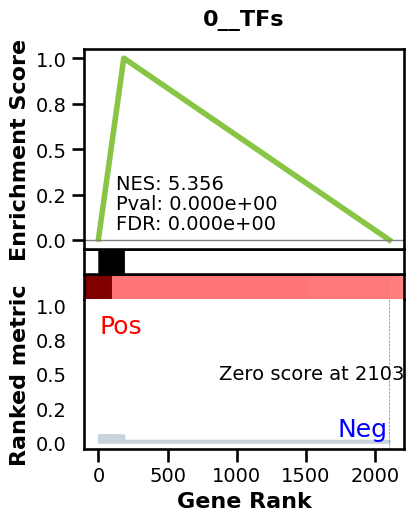

['celltype.gmt__Embryonic stem cells']
_________________________________________
TF specific enrichment


2024-04-10 15:56:15,356:INFO - Downloading and generating Enrichr library gene sets...
2024-04-10 15:56:15,358:INFO - Library is already downloaded in: /home/ml4ig1/.cache/gseapy/Enrichr.ENCODE_TF_ChIP-seq_2014.gmt, use local file
2024-04-10 15:56:15,535:INFO - 0332 gene_sets have been filtered out when max_size=2000 and min_size=0
2024-04-10 15:56:15,545 [WARNING] Duplicated values found in preranked stats: 0.48% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-04-10 15:56:15,712 [WARNING] Duplicated values found in preranked stats: 0.10% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-04-10 15:56:15,875 [WARNING] Duplicated values found in preranked stats: 0.05% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


found!  0__SETDB1
0    1.137397
Name: NES, dtype: object




2024-04-10 15:56:16,243 [WARNING] Duplicated values found in preranked stats: 0.10% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-04-10 15:56:16,420 [WARNING] Duplicated values found in preranked stats: 0.10% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-04-10 15:56:16,570 [WARNING] Duplicated values found in preranked stats: 0.10% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-04-10 15:56:17,041 [WARNING] Duplicated values found in preranked stats: 0.19% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-04-10 15:56:17,406 [WARNING] Duplicated values found in preranked stats: 0.19% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-04-10 15:56:18,087 [WARNING] Duplicated values found in preranked stats: 0.86% of genes
The order of those genes will be

found!  0__CTCF
0    1.152958
Name: NES, dtype: object




2024-04-10 15:56:19,377 [WARNING] Duplicated values found in preranked stats: 0.19% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-04-10 15:56:19,546 [WARNING] Duplicated values found in preranked stats: 0.05% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-04-10 15:56:19,725 [WARNING] Duplicated values found in preranked stats: 0.86% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


found some significant results for  6.0606060606060606 % TFs

_________________________________________
loading GT,  omnipath
intersection of 2104 genes
intersection pct: 1.0
precision:  0.016351416891845078 
recall:  0.6294382397066177 
random recall: 0.1691311856496882



100%|██████████| 49/49 [00:02<00:00, 23.16it/s]


Area Under Precision-Recall Curve (AUPRC):  0.01485912400141912
random precision is:  0.004393655090385227
overal increase: (mean, max) (0.03446875173704147, 0.4603070540569295)
true_positive 181
True Negative:  1351945.0
False Positive:  5782
False Negative:  5818
Odds Ratio:  7.274209329483435


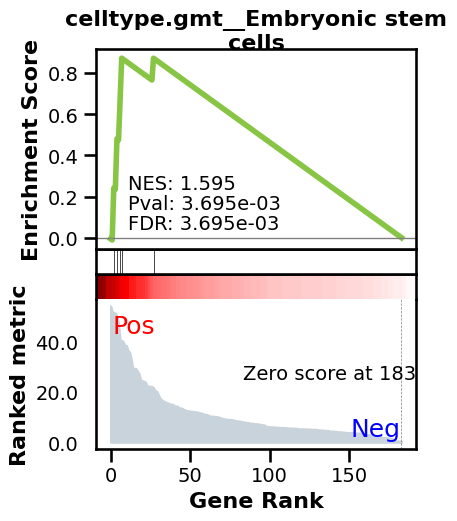

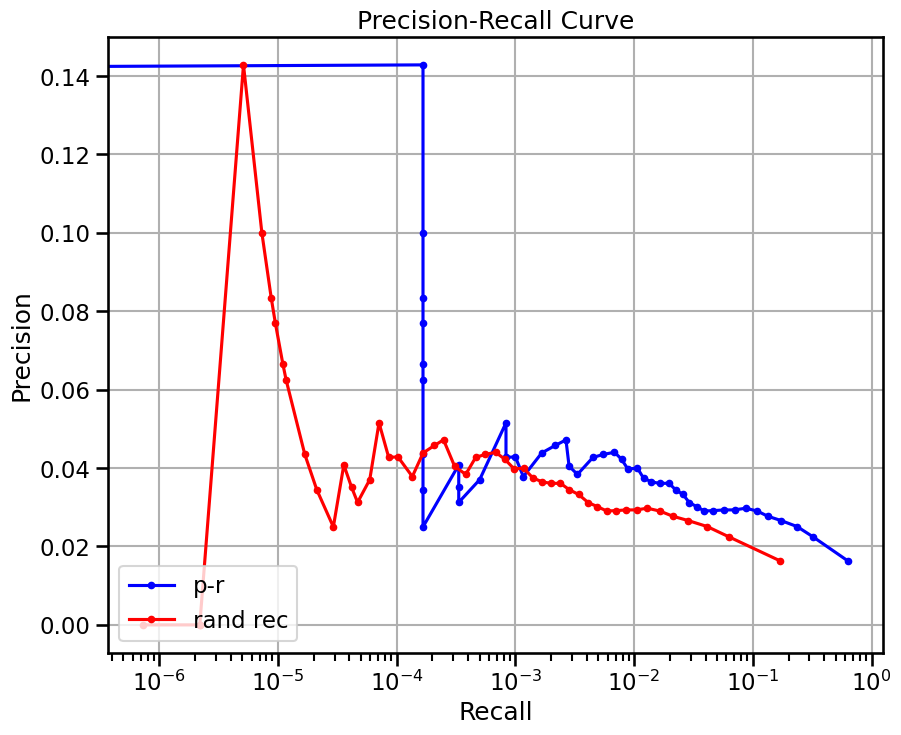

{'enriched_terms_Central': ['0__TFs',
  'celltype.gmt__Embryonic stem cells',
  'celltype.gmt__Epiblast cells'],
 'enriched_terms_Targets': ['celltype.gmt__Embryonic stem cells'],
 'significant_enriched_TFtargets': 6.0606060606060606,
 'auprc': 0.01485912400141912,
 'pr_increase_to_random': (0.03446875173704147, 0.4603070540569295)}

In [68]:
BenGRN(grn).scprint_benchmark()

# Test transformer with TF only

In [ ]:
# just doing the prediction on TFs
# do prediction on only the TF elements, column wise. for the PR, add false to all other elements. and compute PR 

In [ ]:
# TF biased masking and all heads

# test with GT SROY

In [11]:
from bengrn.base import compute_auprc

In [92]:
sgrn = grn.get(list(set(grn.var.index) & set(preadata.grn.loc[preadata.grn.sum(1)>0].index.tolist())))

In [93]:
sub = preadata.grn.loc[sgrn.targets.index, sgrn.targets.columns]
sub[sub.sum(1)!=0].sum(1)
true = set([frozenset([sub.index[i], sub.columns[j]]) for i, j in zip(*np.where(sub>0))])

precision:  0.026402393418100224 
recall:  0.9901823281907434 
random recall: 0.816563349314441 
random precision: 0.021772986838489022


100%|██████████| 49/49 [00:00<00:00, 77.08it/s]


Area Under Precision-Recall Curve (AUPRC):  0.03439524419120186
overal increase: (mean, max) (0.042392458377930924, 0.25851931834403336)
true_positive 20
True Negative:  31342
False Positive:  692
False Negative:  693
Odds Ratio:  1.30712575799281


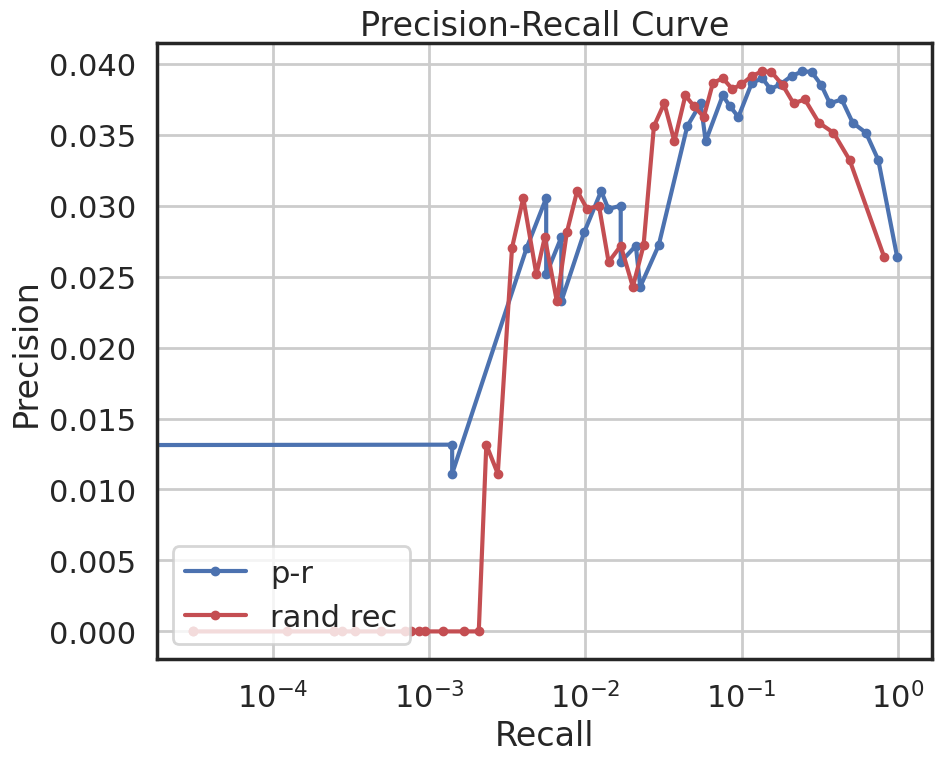

{'auprc': 0.03439524419120186,
 'pr_increase_to_random': (0.042392458377930924, 0.25851931834403336)}

In [94]:
#only on TF
compute_auprc(sgrn.targets.loc[sub.index], true)

precision:  0.02178371234562275 
recall:  0.6704067321178121 
random recall: 0.6700766482425871 
random precision: 0.021772986838489022


100%|██████████| 49/49 [00:00<00:00, 562.45it/s]


Area Under Precision-Recall Curve (AUPRC):  0.018299993872067388
overal increase: (mean, max) (0.0036441148469174467, 0.03742736559361068)
true_positive 22
True Negative:  31343
False Positive:  691
False Negative:  691
Odds Ratio:  1.444132855548179


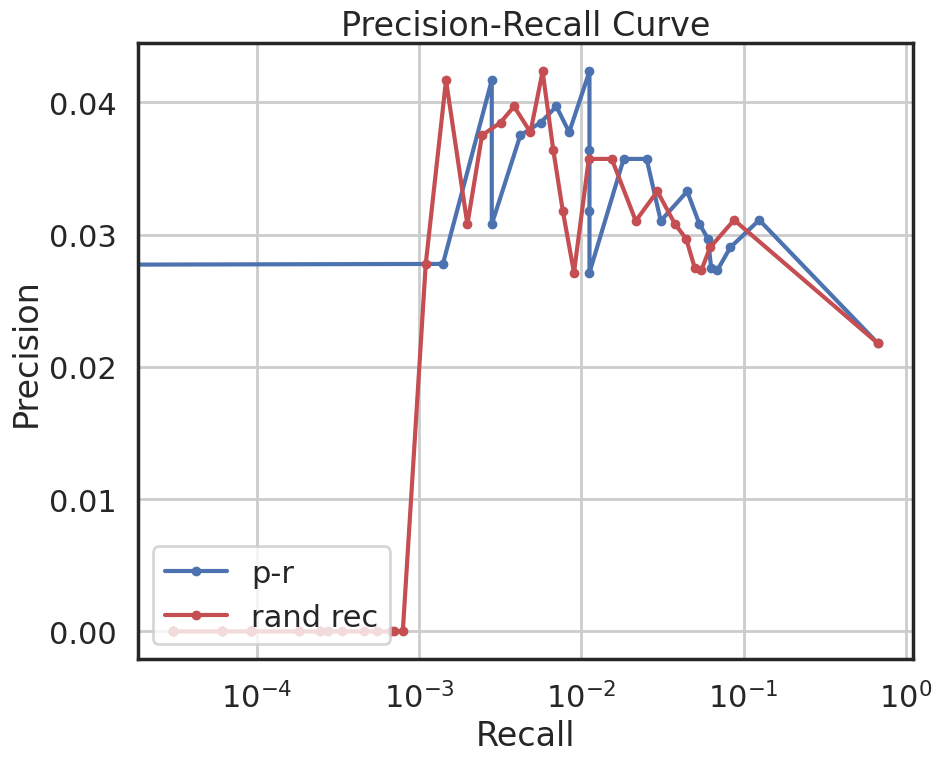

{'auprc': 0.018299993872067388,
 'pr_increase_to_random': (0.0036441148469174467, 0.03742736559361068)}

In [31]:
compute_auprc(sgrn.targets.loc[sub.index], true)

## scprint

In [55]:
adj.shape

(2977, 2977, 96)

array(['EED', 'SALL4', 'TRIM28', 'MYC', 'SETDB1', 'PRDM14', 'ATF3',
       'STAT3', 'JUN', 'ZFP42', 'POU5F1'], dtype=object)

In [58]:
loc = np.array((adata[:, adata.var.index.isin(grn_inferer.curr_genes)].X!=0).sum(0)>2)[0]
curr_genes = adata[:, adata.var.index.isin(np.array(grn_inferer.curr_genes)[loc].tolist())].var.symbol.tolist()

In [85]:
sadj = np.transpose(adj, (1, 0, 2))[np.isin(np.array(curr_genes), sub.index.values)][:, np.isin(np.array(curr_genes), sub.columns.values)]

In [86]:
sadj.shape

(11, 2977, 96)

In [73]:
np.array(curr_genes)[np.isin(np.array(curr_genes), sub.index.values)]

array(['EED', 'SALL4', 'TRIM28', 'MYC', 'SETDB1', 'PRDM14', 'ATF3',
       'STAT3', 'JUN', 'ZFP42', 'POU5F1'], dtype='<U10')

In [75]:
np.array(curr_genes)[np.isin(np.array(curr_genes), sub.columns.values)]

array(['C1orf112', 'GCLC', 'NFYA', ..., 'HMBS', 'SALL3', 'SCO2'],
      dtype='<U10')

In [87]:
da = sub.values.flatten()
sadj = sadj.reshape(-1, adj.shape[-1])


In [88]:
sadj.shape

(32747, 96)

coef [[0.        0.        0.        0.        0.        0.        0.
  0.        0.        0.        0.        0.        0.        0.
  0.        0.        0.        0.        0.        0.        0.
  0.        0.        0.        0.        0.        0.        0.
  0.        0.6770716 0.        0.        0.        0.        0.
  0.        0.        0.        0.        0.        0.        0.
  0.        0.        0.        0.        0.        0.        0.
  0.        0.        0.        0.        0.        0.        0.
  0.        0.        0.        0.        0.        0.        0.
  0.        0.        0.        0.        0.        0.        0.
  0.        0.        0.        0.        0.        0.        0.
  0.        0.        0.        0.        0.        0.        0.
  0.        0.        0.        0.        0.        0.        0.
  0.        0.        0.        0.        0.       ]]


/tmp/ipykernel_664688/3075042393.py:8: RuntimeWarning: invalid value encountered in long_scalars
  print("precision", (pred[y_test==1]==1).sum()/(pred==1).sum())


precision nan
random precision 0.021619640894100404
recall 0.0
random recall 0.0
predicted true 0.0
number of true 354.0


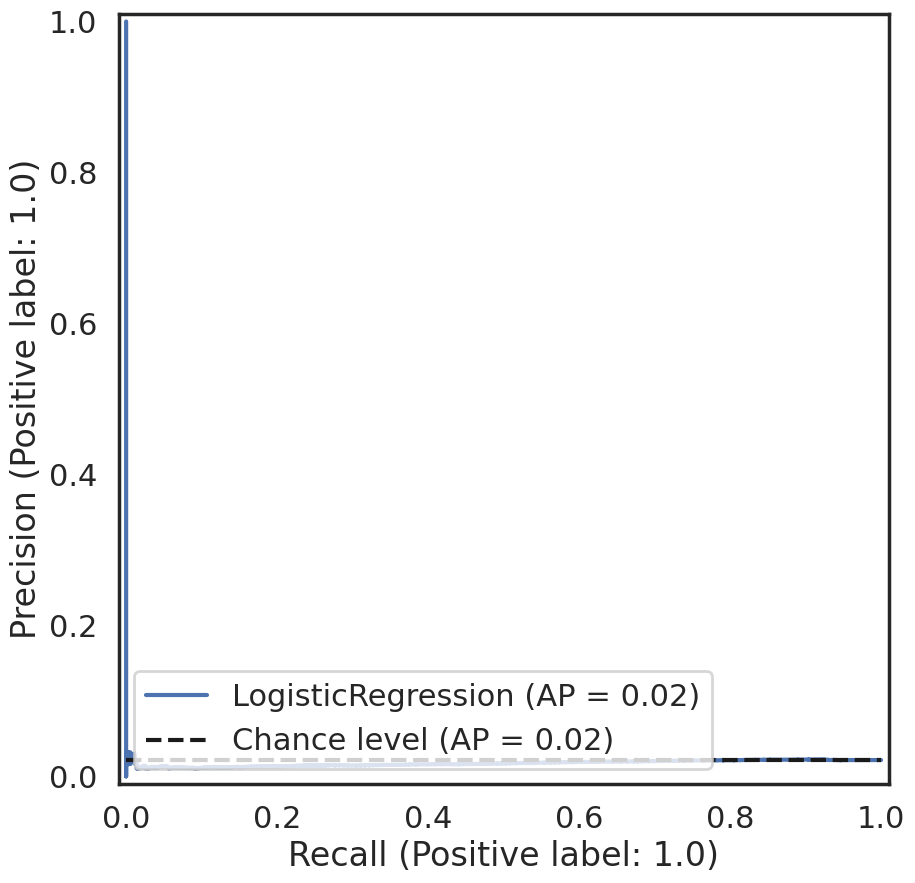

In [89]:
X_train, X_test, y_train, y_test = train_test_split(sadj, da, random_state=0, train_size=0.5)

clf = LogisticRegression(penalty="l1", C=0.4, solver="liblinear", class_weight={1:10,0:1}, max_iter=4_000, n_jobs=8)
clf.fit(X_train, y_train)
print("coef", clf.coef_)

pred = clf.predict(X_test)
print("precision", (pred[y_test==1]==1).sum()/(pred==1).sum())
print("random precision", y_test.sum()/len(y_test))
print("recall", (pred[y_test==1]==1).sum()/y_test.sum())
print("random recall", pred.sum()/len(pred))
print("predicted true", pred.sum())
print("number of true", y_test.sum())
PrecisionRecallDisplay.from_estimator(clf, X_test, y_test, plot_chance_level=True)
plt.show()

coef [[  0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.         162.02418728   0.           0.           0.
    0.           0.           0.           0.          10.02956474
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           

0.16339869281045752
random precision 0.021619640894100404
recall 0.211864406779661
random recall 0.028032246244045437
predicted true 459.0
number of true 354.0


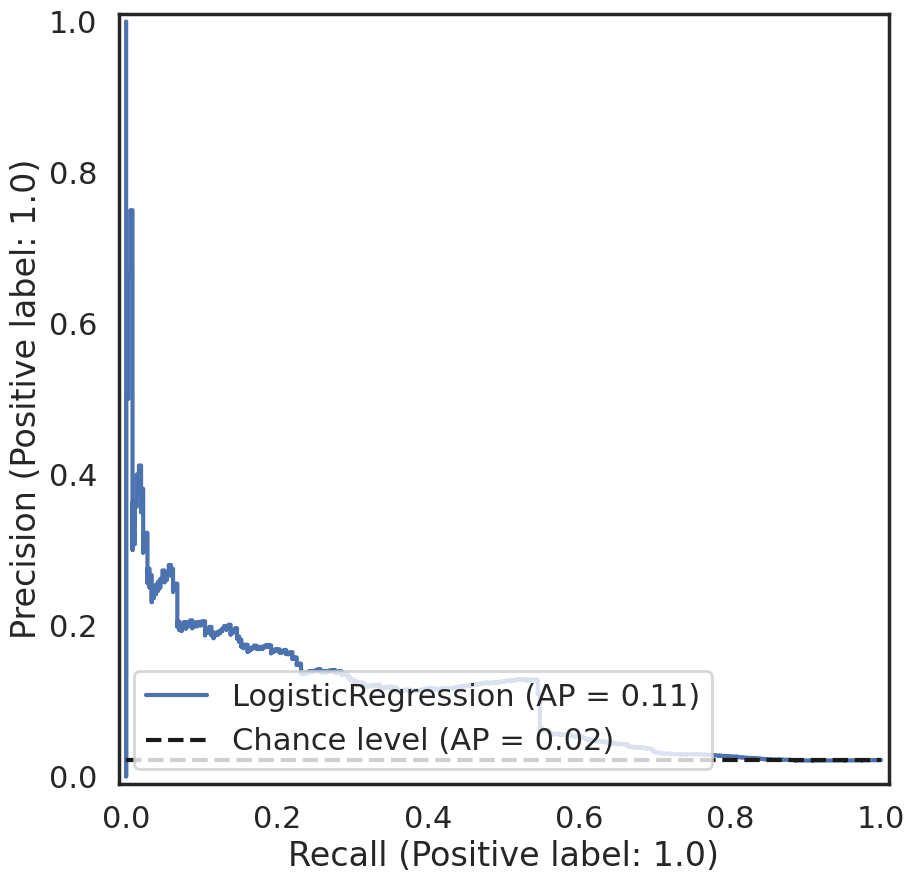

In [82]:
X_train, X_test, y_train, y_test = train_test_split(sadj, da, random_state=0, train_size=0.5)

clf = LogisticRegression(penalty="l1", C=0.4, solver="liblinear", class_weight={1:10,0:1}, max_iter=4_000, n_jobs=8)
clf.fit(X_train, y_train)
print("coef", clf.coef_)

pred = clf.predict(X_test)
print("precision", (pred[y_test==1]==1).sum()/(pred==1).sum())
print("random precision", y_test.sum()/len(y_test))
print("recall", (pred[y_test==1]==1).sum()/y_test.sum())
print("random recall", pred.sum()/len(pred))
print("predicted true", pred.sum())
print("number of true", y_test.sum())
PrecisionRecallDisplay.from_estimator(clf, X_test, y_test, plot_chance_level=True)
plt.show()

In [19]:
len(cu)

['ATF3',
 'CTBP2',
 'EED',
 'JARID2',
 'JUN',
 'MYC',
 'MYCN',
 'POU5F1',
 'PRDM14',
 'REST',
 'SALL4',
 'SETDB1',
 'STAT3',
 'SUZ12',
 'TCF3',
 'TRIM28',
 'ZFP42',
 'ZNF281']

In [ ]:
grn = preadata.grn.loc[preadata.grn.sum(1)>0, preadata.grn.sum(0)>0]
grn = grn.loc[grn.index.isin(curr_genes), grn.columns.isin(curr_genes)]

In [53]:
subadata

GRnnData object with n_obs × n_vars = 457 × 7813
    obs: 'dataset'
    varp: 'GRN'
    with a grn of 2817 elements

# random dataset

In [ ]:
adata = sc.read(
    "data/pancreas_atlas.h5ad",
    backup_url="https://figshare.com/ndownloader/files/24539828",
)

In [ ]:
grn_inferer = GRNfer(model, adata,
    how="most var within",
    preprocess="softmax",
    head_agg='none',
    cell_agg="mean",
    filtration="none",
    forward_mode="none",
    apc=True,
    symmetrize=True,
    max_cells=64,
    #k=
    #genes=
    #known_grn
)
#grn = grn_inferer(layer=list(range(model.nlayers))[:4])

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


number of expressed genes in this cell type: 7586


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

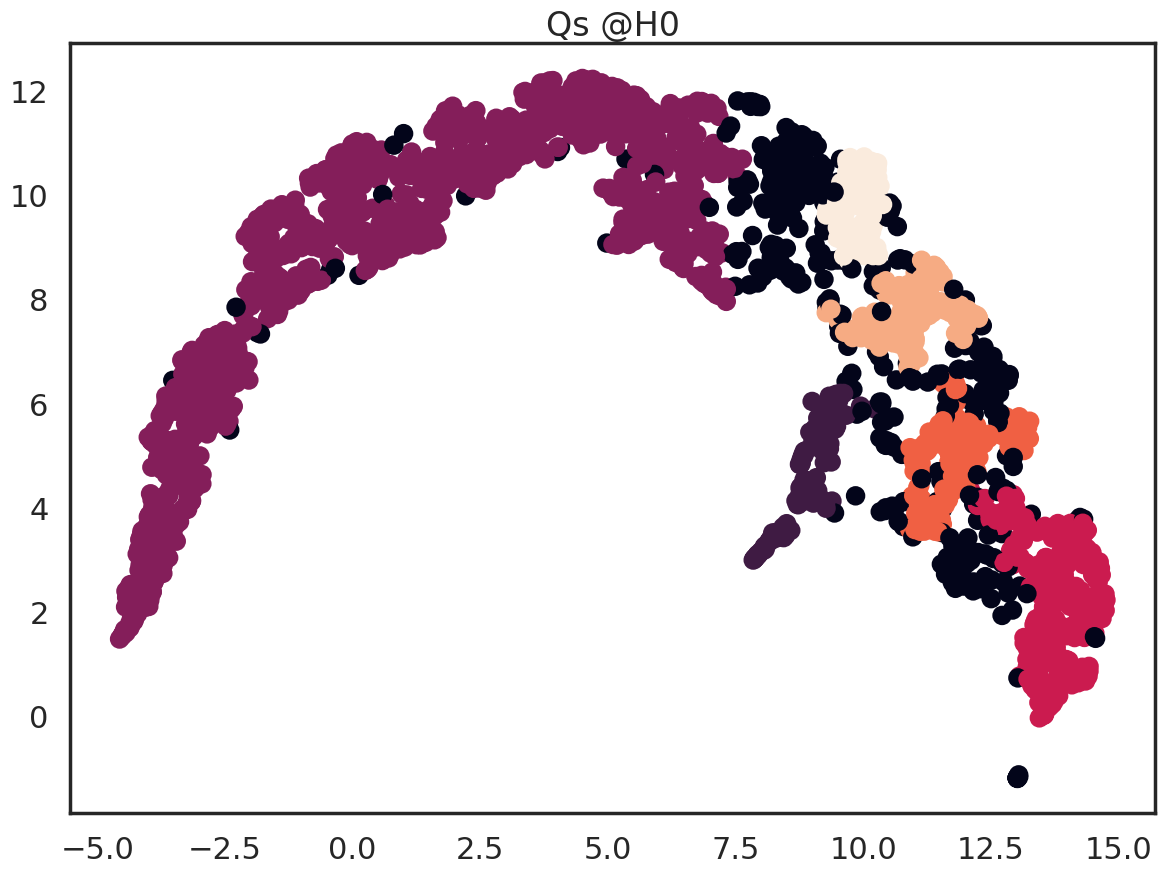

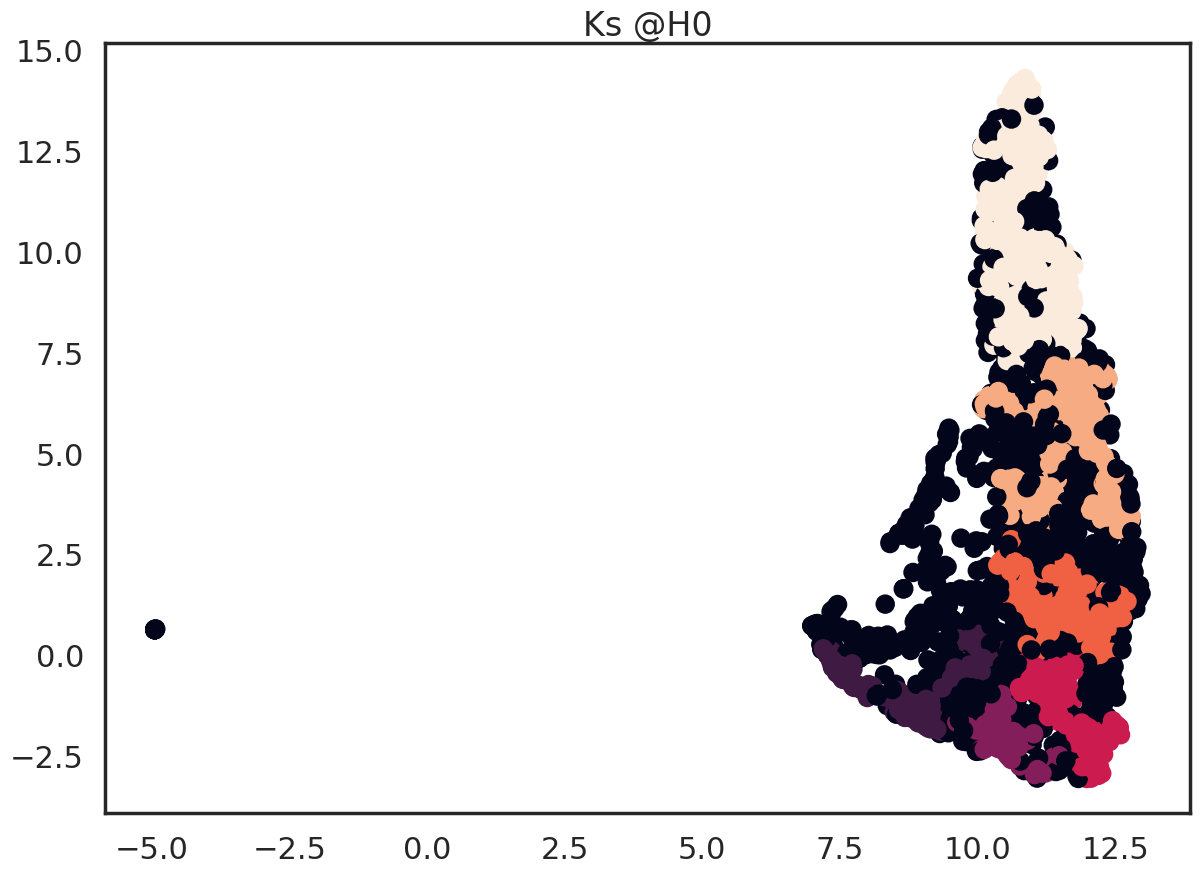

> /home/ml4ig1/Documents code/scPRINT/scprint/tasks/grn.py(273)aggregate()
    271 
    272             pdb.set_trace()
--> 273             attn = torch.nn.functional.softmax(attn, dim=-1)
    274         elif self.preprocess == "none":
    275             pass

    268             attn = attn * attn.shape[-1]
    269         elif self.preprocess == "softmax":
    270             import pdb
    271 
    272             pdb.set_trace()
--> 273             attn = torch.nn.functional.softmax(attn, dim=-1)
    274         elif self.preprocess == "none":
    275             pass
    276         else:
    277             raise ValueError("preprocess must be one of 'sinkhorn', 'softmax', 'none'")
    278 

*** SyntaxError: invalid syntax
tensor([[-20.8315, -20.4803, -22.4715,  ..., -20.9719, -22.4688, -21.4018],
        [-14.2099, -13.7973, -15.6175,  ..., -14.1625, -15.5390, -14.6009],
        [ 11.8695,  12.1280,  10.8608,  ...,  12.1893,  11.7112,  11.8477],
        ...,
        [-17.6487,

In [ ]:
grn = grn_inferer.predict(layer=list(range(model.nlayers))[6:])
adj = grn_inferer.aggregate(grn_inferer.model.mean_attn)